#  Food delivery time prediction

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Load & Understand Data

In [2]:
df_train = pd.read_csv("D:/Datasets/train.csv")
df_train.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [3]:
df_train.columns

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weatherconditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)'],
      dtype='object')

In [4]:
print("Train Dataset :", df_train.shape)

Train Dataset : (45593, 20)


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [6]:
#Check statistical values for fields with numerical datatype
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Restaurant_latitude,45593.0,17.017729,8.185109,-30.905562,12.933284,18.546947,22.728163,30.914057
Restaurant_longitude,45593.0,70.231332,22.883647,-88.366217,73.170000,75.898497,78.044095,88.433452
Delivery_location_latitude,45593.0,17.465186,7.335122,0.010000,12.988453,18.633934,22.785049,31.054057
Delivery_location_longitude,45593.0,70.845702,21.118812,0.010000,73.280000,76.002574,78.107044,88.563452
Vehicle_condition,45593.0,1.023359,0.839065,0.000000,0.000000,1.000000,2.000000,3.000000


In [7]:
#Check statistical values for fields with other than numerical datatype
df_train.describe(exclude=np.number).T

,count,unique,top,freq
ID,45593,45593,0x4607,1
Delivery_person_ID,45593,1320,PUNERES01DEL01,67
Delivery_person_Age,45593,23,35,2262
Delivery_person_Ratings,45593,29,4.8,7148
Order_Date,45593,44,15-03-2022,1192
Time_Orderd,45593,177,NaN,1731
Time_Order_picked,45593,193,21:30:00,496
Weatherconditions,45593,7,conditions Fog,7654
Road_traffic_density,45593,5,Low,15477
Type_of_order,45593,4,Snack,11533


**Observations:**
1. There are null values present in Time_Orderd column.
2. Data Formatting will be required for Weatherconditions & Time_taken(min) column.
2. Both numerical & categorical features are present.
3. ID & Delivery_person_ID will not be used to build the model. 

In [8]:
#Explore each column
for column in df_train.columns:
    print(column)
    print(df_train[column].value_counts())
    print("------------------------------------")

ID
ID
0x4607     1
0x1f3e     1
0xe251     1
0x3f31     1
0x4a78     1
          ..
0xc3f1     1
0x5db7     1
0x1985     1
0xceda     1
0x5fb2     1
Name: count, Length: 45593, dtype: int64
------------------------------------
Delivery_person_ID
Delivery_person_ID
PUNERES01DEL01     67
JAPRES11DEL02      67
HYDRES04DEL02      66
JAPRES03DEL01      66
VADRES11DEL02      66
                   ..
DEHRES18DEL03       7
AURGRES11DEL03      7
KOLRES09DEL03       6
KOCRES16DEL03       6
BHPRES010DEL03      5
Name: count, Length: 1320, dtype: int64
------------------------------------
Delivery_person_Age
Delivery_person_Age
35      2262
36      2260
37      2227
30      2226
38      2219
24      2210
32      2202
22      2196
29      2191
33      2187
28      2179
25      2174
34      2166
26      2159
21      2153
27      2150
39      2144
20      2136
31      2120
23      2087
NaN     1854
50        53
15        38
Name: count, dtype: int64
------------------------------------
Delivery_perso

# Data Cleaning

In [9]:
#Update Column Names
def update_column_name(df):
    #Renaming Weatherconditions column
    df.rename(columns={'Weatherconditions': 'Weather_conditions'},inplace=True)
    
update_column_name(df_train)
print(df_train.columns)

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weather_conditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)'],
      dtype='object')


In [10]:
#Extract relevant values from column
def extract_column_value(df):
    #Extract time and convert to int
    df['Time_taken(min)'] = df['Time_taken(min)'].apply(lambda x: int(x.split(' ')[1].strip()))
    #Extract Weather conditions
    df['Weather_conditions'] = df['Weather_conditions'].apply(lambda x: x.split(' ')[1].strip())
    #Extract city code from Delivery person ID
    df['City_code']=df['Delivery_person_ID'].str.split("RES", expand=True)[0]
    
extract_column_value(df_train)
df_train[['Time_taken(min)','Weather_conditions','City_code']].head()

,Time_taken(min),Weather_conditions,City_code
0,24,Sunny,INDO
1,33,Stormy,BANG
2,26,Sandstorms,BANG
3,21,Sunny,COIMB
4,30,Cloudy,CHEN


In [11]:
#Drop Columns which won't be use for building model
def drop_columns(df):
    df.drop(['ID','Delivery_person_ID'],axis=1,inplace=True)
    
print("Before No. of columns: ",df_train.shape[1])
drop_columns(df_train)
print("After No. of columns: ",df_train.shape[1])

Before No. of columns:  21
After No. of columns:  19


In [12]:
#Check for Duplicate Values
if (len(df_train[df_train.duplicated()])>0):
    print("There are Duplicate values present")
else:
    print("There is no duplicate value present")

There is no duplicate value present


In [13]:
#Update datatypes
def update_datatype(df):
    df['Delivery_person_Age'] = df['Delivery_person_Age'].astype('float64')
    df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].astype('float64')
    df['multiple_deliveries'] = df['multiple_deliveries'].astype('float64')
    df['Order_Date']=pd.to_datetime(df['Order_Date'],format="%d-%m-%Y")
    
update_datatype(df_train)

In [14]:
#Convert String 'NaN' to np.nan
def convert_nan(df):
    df.replace('NaN', float(np.nan), regex=True,inplace=True)

convert_nan(df_train)

In [15]:
#Check null values
df_train.isnull().sum().sort_values(ascending=False)

Delivery_person_Ratings        1908
Delivery_person_Age            1854
Time_Orderd                    1731
City                           1200
multiple_deliveries             993
Weather_conditions              616
Road_traffic_density            601
Festival                        228
Order_Date                        0
Delivery_location_longitude       0
Time_Order_picked                 0
Delivery_location_latitude        0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
Restaurant_longitude              0
Restaurant_latitude               0
Time_taken(min)                   0
City_code                         0
dtype: int64

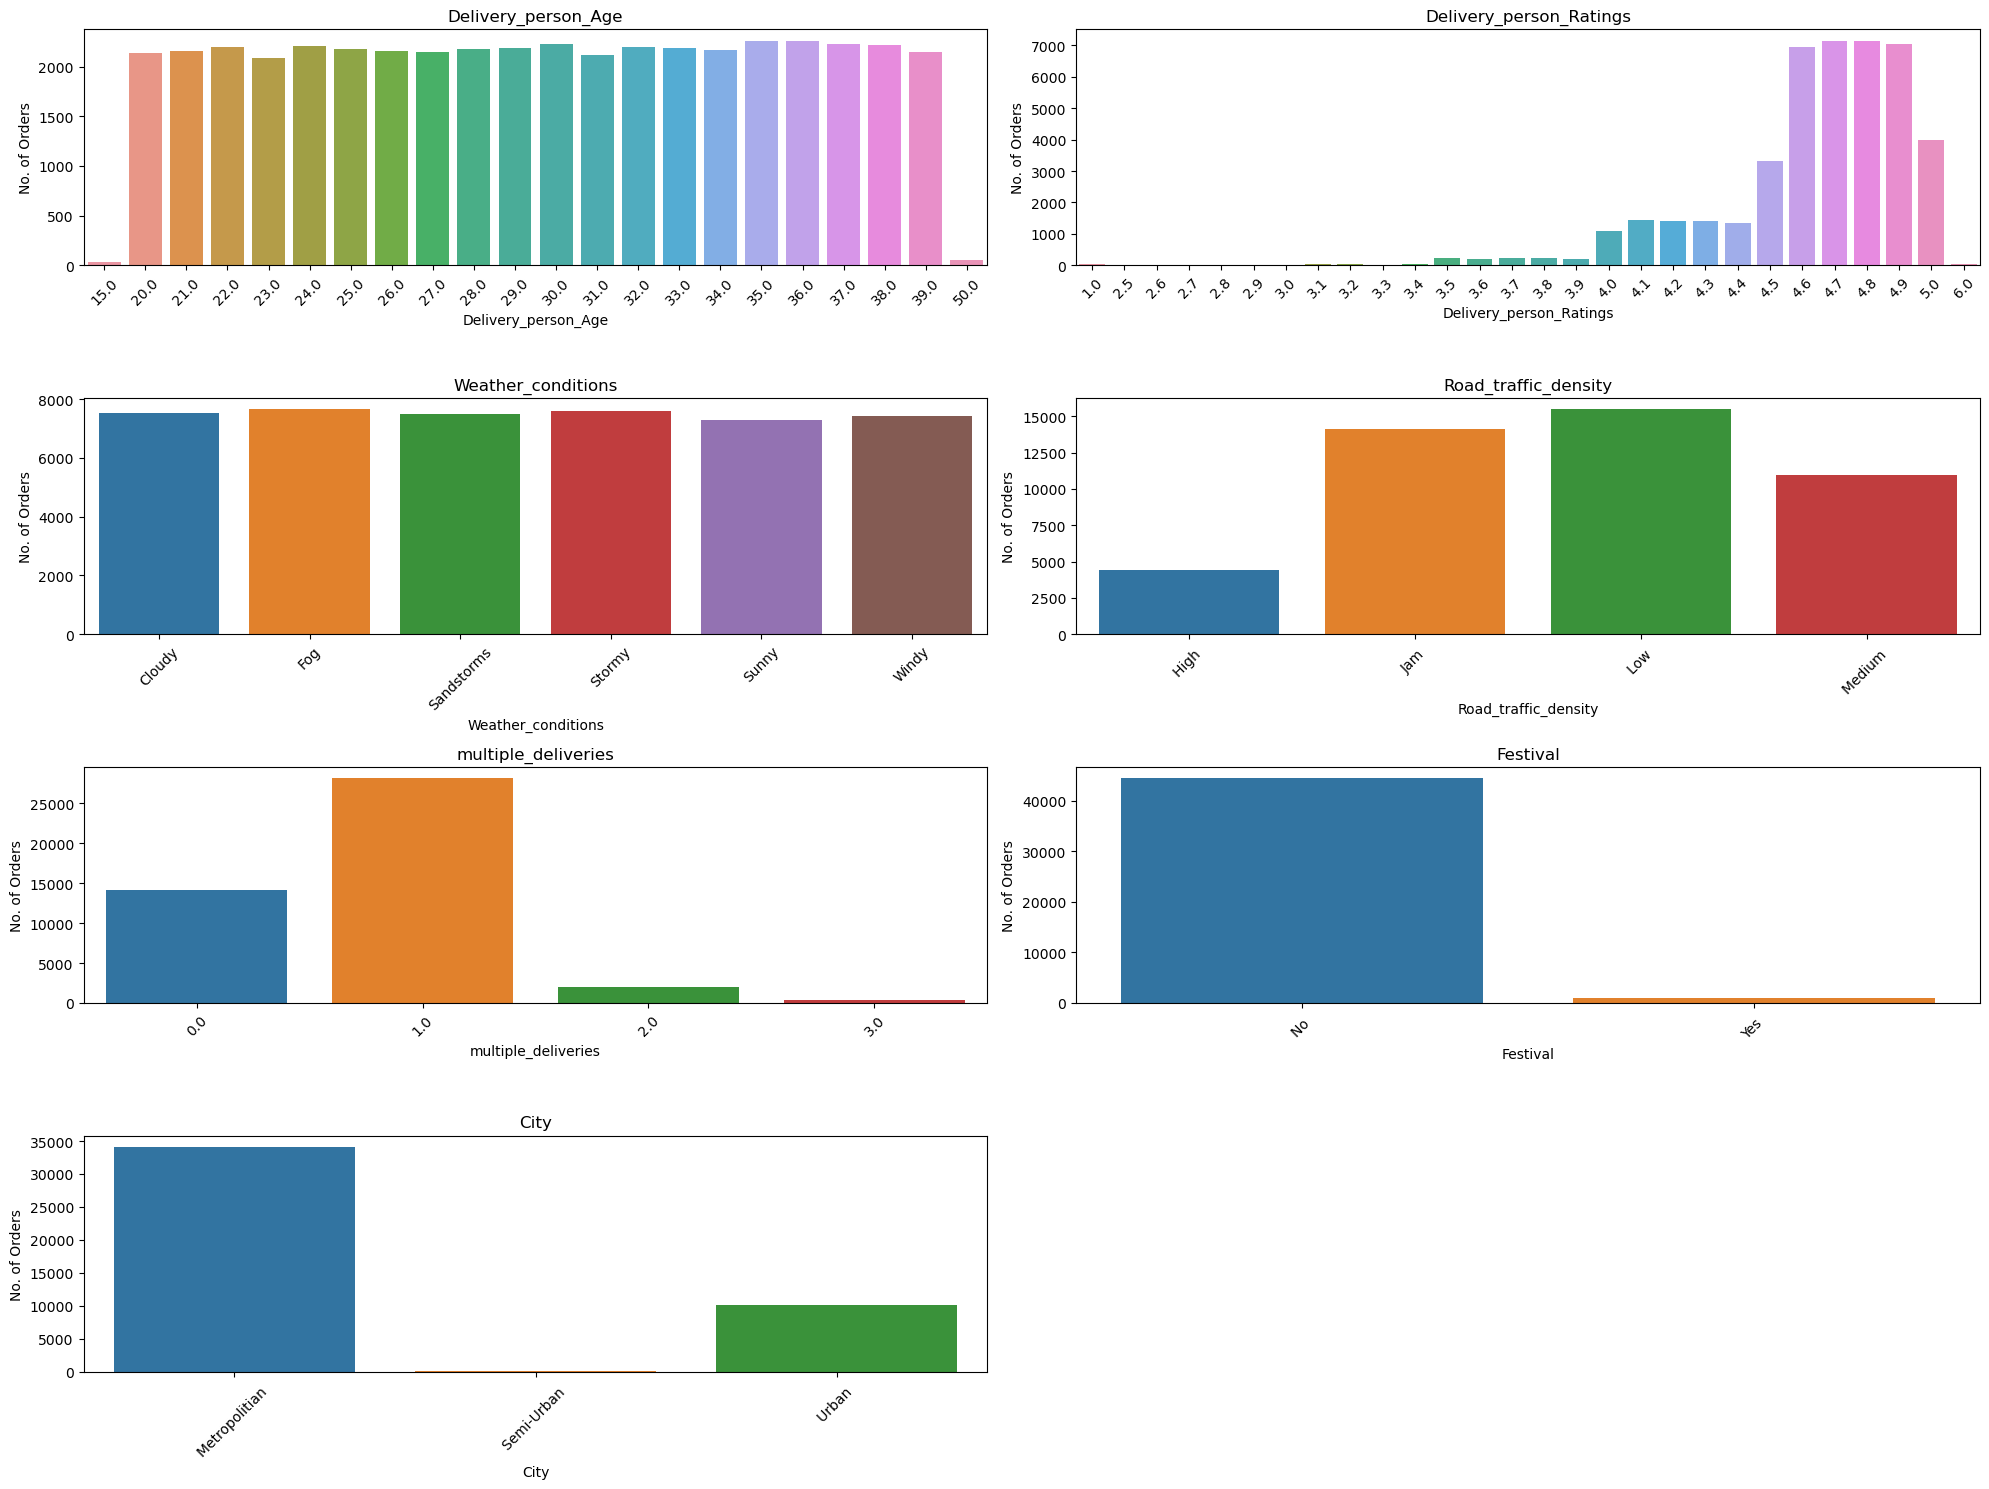

In [16]:
#Let's explore columns that have null values
cols = ['Delivery_person_Age','Delivery_person_Ratings','Weather_conditions','Road_traffic_density','multiple_deliveries','Festival','City']
num_plots = len(cols)
num_rows = (num_plots // 2) + (num_plots % 2)

fig, axes = plt.subplots(num_rows, 2, figsize=(20,15))

for i, column_name in enumerate(cols):
    row = i // 2
    col = i % 2

    ax = axes[row, col]
    sns.countplot(data=df_train, x=column_name, order=df_train[column_name].value_counts().sort_index().index, ax=ax)

    ax.set_xlabel(column_name)
    ax.set_ylabel('No. of Orders')
    ax.set_title(column_name)
    ax.tick_params(axis='x', rotation=45)
    
if num_plots % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

In [17]:
#Handle null values
def handle_null_values(df):
    df['Delivery_person_Age'].fillna(np.random.choice(df['Delivery_person_Age']), inplace=True)
    df['Weather_conditions'].fillna(np.random.choice(df['Weather_conditions']), inplace=True)
    df['City'].fillna(df['City'].mode()[0], inplace=True)
    df['Festival'].fillna(df['Festival'].mode()[0], inplace=True)
    df['multiple_deliveries'].fillna(df['multiple_deliveries'].mode()[0], inplace=True)
    df['Road_traffic_density'].fillna(df['Road_traffic_density'].mode()[0], inplace=True)
    df['Delivery_person_Ratings'].fillna(df['Delivery_person_Ratings'].median(), inplace=True)
    
handle_null_values(df_train)
df_train.isnull().sum()

Delivery_person_Age               0
Delivery_person_Ratings           0
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weather_conditions                0
Road_traffic_density              0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries               0
Festival                          0
City                              0
Time_taken(min)                   0
City_code                         0
dtype: int64

# Feature Engineering

In [18]:
def extract_date_features(data):
    data["day"] = data.Order_Date.dt.day
    data["month"] = data.Order_Date.dt.month
    data["quarter"] = data.Order_Date.dt.quarter
    data["year"] = data.Order_Date.dt.year
    data['day_of_week'] = data.Order_Date.dt.day_of_week.astype(int)
    data["is_month_start"] = data.Order_Date.dt.is_month_start.astype(int)
    data["is_month_end"] = data.Order_Date.dt.is_month_end.astype(int)
    data["is_quarter_start"] = data.Order_Date.dt.is_quarter_start.astype(int)
    data["is_quarter_end"] = data.Order_Date.dt.is_quarter_end.astype(int)
    data["is_year_start"] = data.Order_Date.dt.is_year_start.astype(int)
    data["is_year_end"] = data.Order_Date.dt.is_year_end.astype(int)
    data['is_weekend'] = np.where(data['day_of_week'].isin([5,6]),1,0)

extract_date_features(df_train)
df_train.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,...,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,...,1,2022,5,0,0,0,0,0,0,1
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,...,1,2022,4,0,0,0,0,0,0,0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,...,1,2022,5,0,0,0,0,0,0,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,...,2,2022,1,0,0,0,0,0,0,0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,...,1,2022,5,0,0,0,0,0,0,1


In [22]:

def calculate_time_diff(df):
    # Convert columns to datetime if they are not already
    df['Time_Orderd'] = pd.to_timedelta(df['Time_Orderd'])
    df['Time_Order_picked'] = pd.to_timedelta(df['Time_Order_picked'])
    
    df['Time_Order_picked_formatted'] = df['Order_Date'] + np.where(df['Time_Order_picked'] < df['Time_Orderd'], pd.DateOffset(days=1), pd.DateOffset(days=0)) + df['Time_Order_picked']
    df['Time_Ordered_formatted'] = df['Order_Date'] + df['Time_Orderd']
    
    df['order_prepare_time'] = (pd.to_datetime(df['Time_Order_picked_formatted']) - pd.to_datetime(df['Time_Ordered_formatted'])).dt.total_seconds() / 60

    # Handle null values by filling with the median
    df['order_prepare_time'].fillna(df['order_prepare_time'].median(), inplace=True)
    
    # Drop all the time & date related columns
    df.drop(['Time_Orderd', 'Time_Order_picked', 'Time_Ordered_formatted', 'Time_Order_picked_formatted', 'Order_Date'], axis=1, inplace=True)

# Apply the function to your DataFrame
calculate_time_diff(df_train)


In [23]:
#Calculate distance between restaurant location & delivery location
def calculate_distance(df):
    df['distance']=np.zeros(len(df))
    restaurant_coordinates=df[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
    delivery_location_coordinates=df[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()
    df['distance'] = np.array([geodesic(restaurant, delivery) for restaurant, delivery in zip(restaurant_coordinates, delivery_location_coordinates)])
    df['distance']= df['distance'].astype("str").str.extract('(\d+)').astype("int64")
    
calculate_distance(df_train)
df_train.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,...,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,distance
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,High,2,Snack,...,5,0,0,0,0,0,0,1,15.0,3
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,Stormy,Jam,2,Snack,...,4,0,0,0,0,0,0,0,5.0,20
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Sandstorms,Low,0,Drinks,...,5,0,0,0,0,0,0,1,15.0,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Sunny,Medium,0,Buffet,...,1,0,0,0,0,0,0,0,10.0,7
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Cloudy,High,1,Snack,...,5,0,0,0,0,0,0,1,15.0,6


# Data Preprocessing

## Label Encoding

In [24]:
def label_encoding(df):
    categorical_columns = df.select_dtypes(include='object').columns
    label_encoder = LabelEncoder()
    df[categorical_columns] = df[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))

label_encoding(df_train)
df_train.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,...,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,distance
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,4,0,2,3,...,5,0,0,0,0,0,0,1,15.0,3
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,3,1,2,3,...,4,0,0,0,0,0,0,0,5.0,20
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2,2,0,1,...,5,0,0,0,0,0,0,1,15.0,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,4,3,0,0,...,1,0,0,0,0,0,0,0,10.0,7
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,0,0,1,3,...,5,0,0,0,0,0,0,1,15.0,6


## Train test split

In [25]:
#Split features & label
X = df_train.drop('Time_taken(min)', axis=1)  # Features
y = df_train['Time_taken(min)']  # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(36474, 29)
(36474,)
(9119, 29)
(9119,)


## Standardization

In [26]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Perform standardization on the training data
X_train = scaler.transform(X_train)

# Perform standardization on the testing data
X_test = scaler.transform(X_test)

# Model Building

### Steps
1. Employ cross-validation & hyper parameter tuning to determine the optimal regression model.
2. Construct the food delivery prediction model using the identified best model.
3. Evaluate the model's performance on the testing data to assess its accuracy and reliability.

### Cross Validation

In [27]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Find the best model
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    xgb.XGBRegressor(),
]

param_grid = [
    {},  
    {'max_depth': [3, 5, 7]},
    {'n_estimators': [100, 200, 300]},
    {'n_estimators': [20, 25, 30], 'max_depth': [5, 7, 9]},
]

for i, model in enumerate(models):
    grid_search = GridSearchCV(model, param_grid[i], cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)

    print(f"{model.__class__.__name__}:")
    print("Best parameters:", grid_search.best_params_)
    print("Best R2 score:", grid_search.best_score_)
    print()

LinearRegression:
Best parameters: {}
Best R2 score: 0.4224405870217506

DecisionTreeRegressor:
Best parameters: {'max_depth': 7}
Best R2 score: 0.7339168443001622

RandomForestRegressor:
Best parameters: {'n_estimators': 300}
Best R2 score: 0.8134101906019394

XGBRegressor:
Best parameters: {'max_depth': 7, 'n_estimators': 20}
Best R2 score: 0.821289644634861



### Model Building

In [31]:
# Create a XGB regressor model
model = xgb.XGBRegressor(n_estimators=20,max_depth=9)

# Fit the model on the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

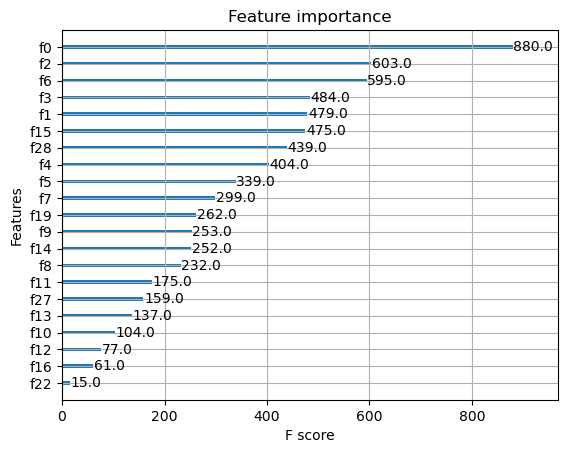

In [33]:
# Plot feature importance
xgb.plot_importance(model)
plt.show()

### Model Evaluation

In [29]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", round(mae,2))
print("Mean Squared Error (MSE):", round(mse,2))
print("Root Mean Squared Error (RMSE):", round(rmse,2))
print("R-squared (R2) Score:", round(r2,2))

Mean Absolute Error (MAE): 3.15
Mean Squared Error (MSE): 15.82
Root Mean Squared Error (RMSE): 3.98
R-squared (R2) Score: 0.82


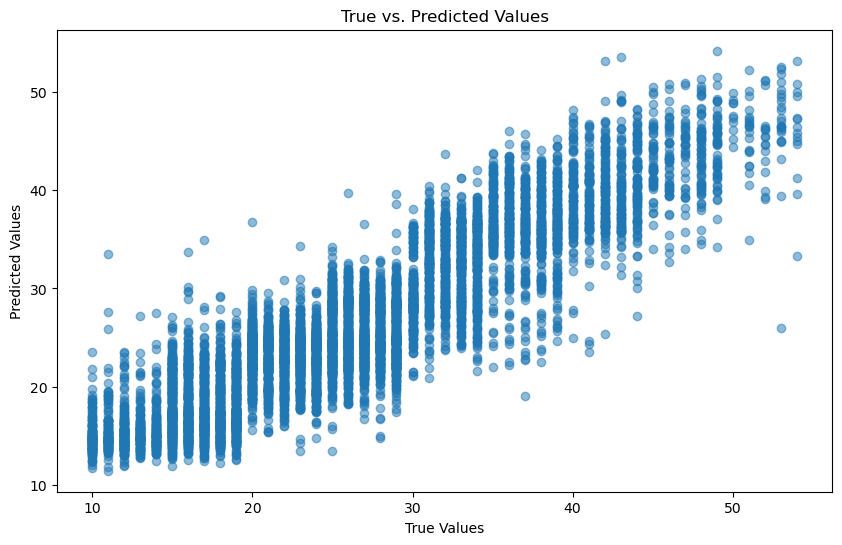

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values")
plt.show()


It seems that there is the strong positive relationship between Actual values and Predicted values.

# Conclusion

In conclusion, the food delivery prediction model was developed using XGBoost, achieving an impressive R2 score of 0.82. 
Moving forward, potential enhancements include identifying the best features, conducting additional feature engineering, and exploring other optimization techniques to further improve the model's performance and accuracy. 
These steps will contribute to fine-tuning the model and unlocking its full potential in predicting food delivery timings accurately.